# Modifying orbital characteristics with *SpeedyWeather*

### Notebook by Dr Alex Baker, NCAS / Univ. Reading

In this notebook, we simulate the effect of making significant changes to Earth's planetary characteristics. In three separate experiments, we will modify Earth's **axial tilt**, its **radius** and **gravitational acceleration**, and its **rotational frequency**.

**Experiment #1 — reduce Earth's axial tilt:**

Orbital quantities vary or evolve over multi-milennial timescales. Axial tilt (with respect to the orbital plane, or *ecliptic*) varies between 22.1$\degree$ and 24.5$\degree$ with a periodicity of ~41,000 years. This *obliquity* is one of the Croll-Milankovitch cycles in Earth's orbital geometry, which have paced Quaternary climate fluctuations (Hays *et al*., 1976). Axial tilt is a key factor in the seasonality extant in Earth's climate. In this experiment, we will halve axial tilt from its present-day value of 23.4$\degree$ to 11.7$\degree$.

**Experiment #2 — mimic Mars' radius and *g*:**

Earth is an oblate spheroid, a quasi-sphere with an equatorial radius that slightly exceeds its polar radius (i.e., Earth slightly bulges at the equator). This is also true of Mars. In this experiment, we will reduce the planetary radius and value of *g* to those of Mars. For simplicity, we will reduce a mean radius from 6,371 km to 3,373 km, and we will reduce *g* from 9.81 ms$^{-1}$ to 3.69 ms$^{-1}$.

**Experiment #3 — reduce Earth's rotational frequency:**

Due to tidal friction by the Moon, Earth's rotation rate experiences high-frequency modulation and, over deep Earth history, has slowed (see [here](https://core2.gsfc.nasa.gov/ggfc/tides/intro.html) for a few helpful references). Rotation induces the Coriolis effect, which is responsible for phenomena such as cyclones and trade winds. In this experiment, we will halve the rotational frequency and see how such a dramatic change could affect climate. Note two things: (i) that this won't change the length of a day, as this is hard-coded in *SpeedyWeather.jl*, so we're essentially reducing the Coriolis effect (perhaps more of a science-fiction experiment); (ii) we use a reduced timestep for model stability.

**References**

Hays, J. D., Imbrie, J., and Shackleton, N. J., 1976. [Variations in the Earth's Orbit: Pacemaker of the Ice Ages](https://www.science.org/doi/10.1126/science.194.4270.1121). *Science* **194**, 1121-1132.

** **

**.jl packages**

In [1]:
using SpeedyWeather
using GeoMakie
using CairoMakie
using Dates

**1. Define experiment: name, grid, timestep, duration, and planet**

Experiment #1

In [2]:
experiment_name = "orbital_half_tilt"
spectral_grid = SpectralGrid(trunc=31, dealiasing=3, nlayers=8)
timestep = 40
duration_yr = 10
earth = Earth(spectral_grid,axial_tilt=11.7)  # unit is degrees
earth

Earth{Float32} <: SpeedyWeather.AbstractPlanet
├ rotation::Float32 = 7.29e-5
├ gravity::Float32 = 9.81
├ daily_cycle::Bool = true
├ length_of_day::Second = 86400 seconds
├ seasonal_cycle::Bool = true
├ length_of_year::Second = 31557600 seconds
├ equinox::DateTime = 2000-03-20T00:00:00
├ axial_tilt::Float32 = 11.7
└ solar_constant::Float32 = 1365.0

Experiment #2

In [ ]:
experiment_name = "orbital_mars"
spectral_grid = SpectralGrid(trunc=31, dealiasing=3, nlayers=8, radius = 3.3727e6)
timestep = 40
duration_yr = 10
earth = Earth(spectral_grid, gravity=3.69)  # unis is m/s-2
earth

Experiment #3

In [ ]:
experiment_name = "orbital_half_rotation"
spectral_grid = SpectralGrid(trunc=31, dealiasing=3, nlayers=8)
timestep = 15
duration_yr = 10
earth = Earth(spectral_grid)
earth.rotation *= 0.5   # half the rotation rate; unit is rad/s
earth

Note that you may run `?Earth` to inspect the meanings of parameters

**2. Define the output**

Specify additional outputs or use `SpeedyWeather.AllOutputVariables()` (n.b., expansion: `...` in Julia is equivalent to `*` in Python)

In [3]:
output_ctl = NetCDFOutput(spectral_grid, PrimitiveWetModel, path="/Users/bakera/Desktop/output/", id="control", output_dt=Month(1))
add!(output_ctl, SpeedyWeather.AllOutputVariables()...)
#add!(output_ctl, SpeedyWeather.TemperatureOutput(), SpeedyWeather.LargeScalePrecipitationOutput(), SpeedyWeather.ConvectivePrecipitationOutput(), SpeedyWeather.DivergenceOutput(), SpeedyWeather.SurfaceFluxesOutput()..., SpeedyWeather.RadiationOutput()..., SpeedyWeather.SoilTemperatureOutput())
output_exp = NetCDFOutput(spectral_grid, PrimitiveWetModel, path="/Users/bakera/Desktop/output/", id=experiment_name, output_dt=Month(1))
add!(output_exp, SpeedyWeather.AllOutputVariables()...)
#add!(output_exp, SpeedyWeather.TemperatureOutput(), SpeedyWeather.LargeScalePrecipitationOutput(), SpeedyWeather.ConvectivePrecipitationOutput(), SpeedyWeather.DivergenceOutput(), SpeedyWeather.SurfaceFluxesOutput()..., SpeedyWeather.RadiationOutput()..., SpeedyWeather.SoilTemperatureOutput())

NetCDFOutput{Field{Float32, 1, Vector{Float32}, FullGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}}
├ status: inactive/uninitialized
├ write restart file: true (if active)
├ interpolator: AnvilInterpolator{Float32, SpeedyWeather.RingGrids.GridGeometry{OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}, Vector{Float32}, Vector{Int64}}, SpeedyWeather.RingGrids.AnvilLocator{Float32, Vector{Float32}, Vector{Int64}}}
├ path: output.nc (overwrite=false)
├ frequency: 2592000 seconds
└┐ variables:
 ├ sma: soil moisture availability [1]
 ├ random_pattern: random pattern [1]
 ├ sru: Surface shortwave radiation up [W/m^2]
 ├ ef: Surface humidity fluxes (positive up) [kg/s/m^2]
 ├ lsm: land-sea mask (1=land, 0=sea) [1]
 ├ st: soil temperature [degC]
 ├ temp: temperature [degC]
 ├ pres: surface pressure [hPa]
 ├ precip_cond: accumulated large-scale precipitation [mm

**3. Create land and ocean model components**

In [4]:
temperature = LandBucketTemperature(spectral_grid)
soil_moisture = LandBucketMoisture(spectral_grid)
land = LandModel(spectral_grid; temperature, soil_moisture)
ocean = SlabOcean(spectral_grid)

SlabOcean{Float32} <: AbstractOcean
├ temp_equator::Float32 = 302.0
├ temp_poles::Float32 = 273.0
├ specific_heat_capacity::Float32 = 4184.0
├ mixed_layer_depth::Float32 = 10.0
├ density::Float32 = 1000.0
├ mask::Bool = false
└ heat_capacity_mixed_layer::Float32 = 4.184e7

**4. Make parameterisation choices, set timestepping, apply fixes**

In [5]:
large_scale_condensation = ImplicitCondensation(spectral_grid)
convection = SimplifiedBettsMiller(spectral_grid)

time_stepping_ctl = Leapfrog(spectral_grid, Δt_at_T31=Minute(40))  # CPL this is the standard time step
time_stepping_exp = Leapfrog(spectral_grid, Δt_at_T31=Minute(timestep))

albedo = Albedo(GlobalConstantAlbedo(spectral_grid, albedo=0.06), AlbedoClimatology(spectral_grid))  # fix ocean albedo
#set!(albedo.land, (λ, φ) -> 0., add=true)  # set albedo offset for diffuse radiation

Albedo <: SpeedyWeather.AbstractAlbedo
├ ocean: GlobalConstantAlbedo{Float32}
└ land: AlbedoClimatology{Float32, Field{Float32, 1, Vector{Float32}, OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}}

**5. Create models and initialise simulations**

In [6]:
model_ctl = PrimitiveWetModel(spectral_grid; land, ocean, large_scale_condensation, convection, time_stepping=time_stepping_ctl, output=output_ctl)
model_exp = PrimitiveWetModel(spectral_grid; land, ocean, large_scale_condensation, convection, time_stepping=time_stepping_exp, planet=earth, output=output_exp)

simulation_ctl = initialize!(model_ctl)
simulation_exp = initialize!(model_exp)

model_exp

PrimitiveWetModel <: PrimitiveWet
├ spectral_grid: SpectralGrid{SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}, Spectrum...
├ architecture: SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}
├ dynamics: Bool
├ geometry: Geometry{Float32, OctahedralGaussianGrid{SpeedyWeather.Architectures.CPU{KernelAbst...
├ planet: Earth{Float32}
├ atmosphere: EarthAtmosphere{Float32}
├ coriolis: Coriolis{Float32, Vector{Float32}}
├ geopotential: Geopotential{Float32, Vector{Float32}}
├ adiabatic_conversion: AdiabaticConversion{Float32, Vector{Float32}}
├ particle_advection: NoParticleAdvection
├ initial_conditions: InitialConditions{ZonalWind, PressureOnOrography, JablonowskiTemperature,...
├ forcing: NoForcing
├ drag: NoDrag
├ random_process: NoRandomProcess
├ tracers: Dict{Symbol, Tracer}
├ orography: EarthOrography{Float32, Field{Float32, 1, Vector{Float32}, OctahedralGaussianGrid{...
├ land_sea_mask: EarthLandSeaMask{Float32, Field{Float32, 1, Vector{Float32}, OctahedralGaussia...
├ 

**6. Run the control and peturbed experiment simulations**

In [7]:
run!(simulation_ctl, period=Year(duration_yr), output=true)
run!(simulation_exp, period=Year(duration_yr), output=true)

Weather is speedy: run_control_0001 100%|█| Time: 0:11:40 (1233.72 years/day)
Weather is speedy: run_orbital_half_tilt_0001 100% Time: 0:11:32 (1248.53 years/day)


Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

**7. Plot simple difference maps**

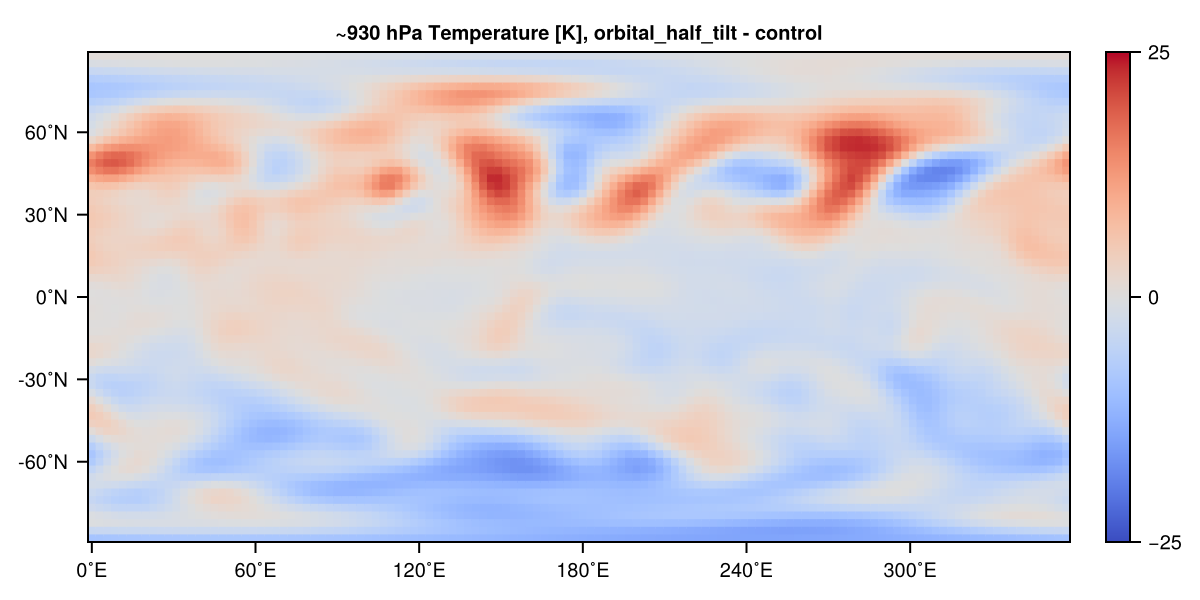

In [8]:
T = simulation_exp.diagnostic_variables.grid.temp_grid[:, end] - simulation_ctl.diagnostic_variables.grid.temp_grid[:, end]
heatmap(T, colorrange=(-25,25), colormap = "coolwarm", title="~930 hPa Temperature [K], "*experiment_name*" - control")

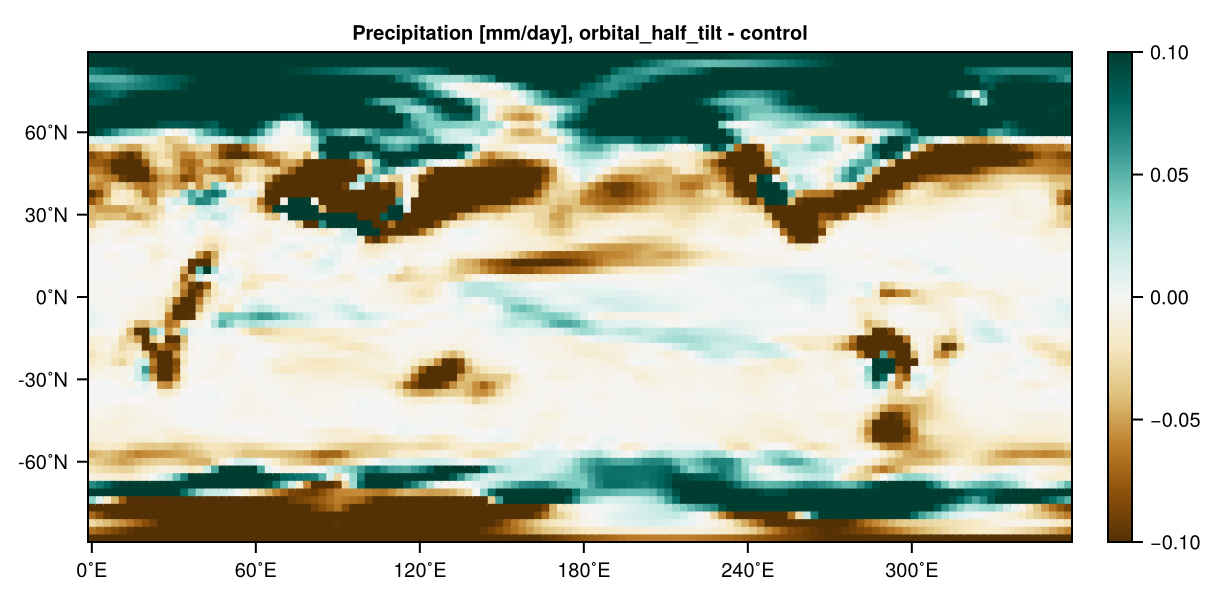

In [9]:
P = simulation_exp.diagnostic_variables.physics.precip_large_scale - simulation_ctl.diagnostic_variables.physics.precip_large_scale
heatmap(P, colorrange=(-0.1,0.1), colormap = "BrBG", title="Precipitation [mm/day], "*experiment_name*" - control")

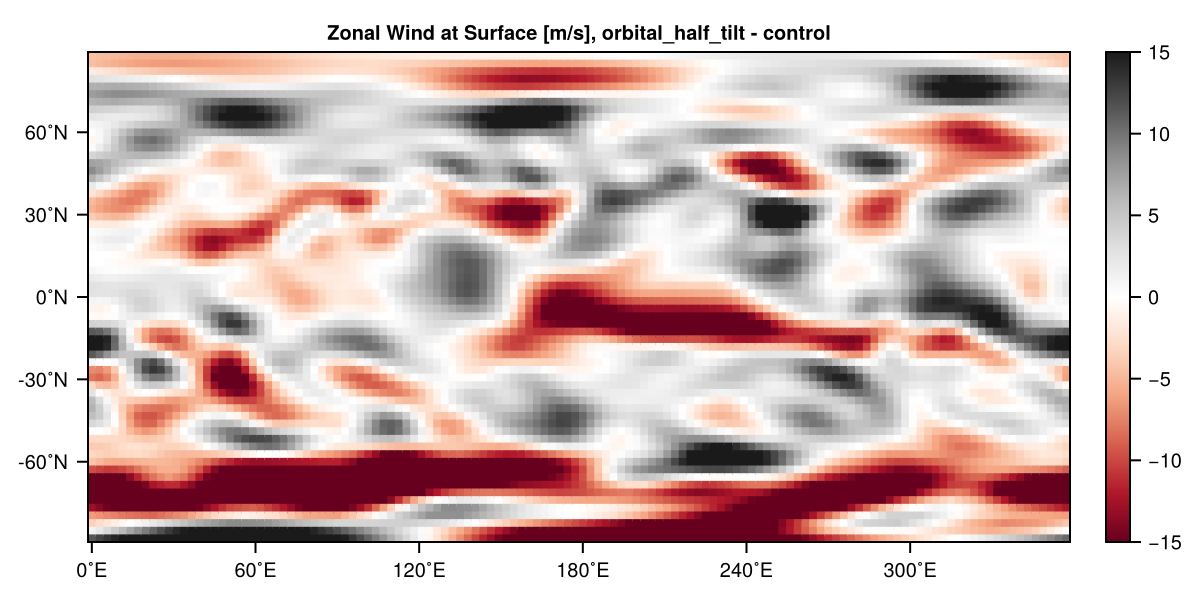

In [10]:
U = simulation_exp.diagnostic_variables.grid.u_grid[:, end] - simulation_ctl.diagnostic_variables.grid.u_grid[:, end]
heatmap(U, colorrange=(-15,15), colormap = "RdGy", title="Zonal Wind at Surface [m/s], "*experiment_name*" - control")